## Stock Open Gap Prediction

> This Notebook runs a Machine Learning process based on Logistic Regression to predict open gaps using a customized signal_threshold.

> It uses yahoo finance for data

In [167]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras import metrics
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, concatenate
import keras.backend as K
from keras.utils import plot_model
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , mean_squared_error , mean_absolute_error , classification_report, log_loss, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras import regularizers
from xgboost import XGBClassifier
import scipy.stats as stats
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback, EarlyStopping
import seaborn as sns
import time
from scipy.optimize import minimize
import yfinance as yf
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
train_start = '2010-01-01'
train_end   = '2021-12-31'


test_start  = '2022-01-01'
test_end    = '2023-06-30'

stock_symb  = 'MSFT'

gap = 0.02
signal_threshold = 0.60

In [169]:
my_factors = 'NG=F, CL=F, GC=F, GOVT, ^VIX, ^GDAXI, ^HSI, ^N225, EURUSD=X, USDJPY=X, BTC-USD, ETH-USD, ACWI, SPY, QQQ, IWB'

my_factors = yf.download(my_factors,start=train_start, end=test_end)['Adj Close']
my_factors = np.log1p(my_factors.pct_change())
my_factors

[*********************100%***********************]  16 of 16 completed


/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


,ACWI,BTC-USD,CL=F,ETH-USD,EURUSD=X,GC=F,GOVT,IWB,NG=F,QQQ,SPY,USDJPY=X,^GDAXI,^HSI,^N225,^VIX
Date,,,,,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01,0.000000,NaN,0.000000,NaN,0.004379,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000108,NaN,NaN,NaN,0.000000
2010-01-04,0.020364,NaN,0.026731,NaN,0.002363,0.020336,NaN,0.016340,0.054483,0.014538,0.016818,-0.004584,NaN,NaN,NaN,-0.078660
2010-01-05,0.008306,NaN,0.003185,NaN,-0.004031,0.000358,NaN,0.003204,-0.042885,0.000000,0.002644,-0.009887,-0.002722,0.020693,0.002535,-0.035038
2010-01-06,-0.000230,NaN,0.017097,NaN,0.002647,0.015795,NaN,0.001279,0.063906,-0.006050,0.000704,0.008383,0.000409,0.006134,0.004635,-0.009868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,0.005849,-0.004541,0.026661,-0.008562,-0.001380,0.000100,0.005133,0.008236,0.023086,0.006875,0.008499,0.002522,0.007687,0.002733,0.013915,-0.076233
2023-04-29,0.000000,-0.003133,0.000000,0.008631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-04-30,0.000000,0.000694,0.000000,-0.016902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### STOCK

In [170]:
stock = yf.download(stock_symb,start=train_start, end=test_end)
stock['Gap'] = 1*(stock['Open'].shift(-1) / stock['Close'] -1)
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Gap
Date,,,,,,,
2009-12-31,30.980000,30.990000,30.480000,30.480000,23.265152,31929700,0.004593
2010-01-04,30.620001,31.100000,30.590000,30.950001,23.623899,38409100,-0.003231
2010-01-05,30.850000,31.100000,30.639999,30.959999,23.631531,49749600,-0.002584
2010-01-06,30.879999,31.080000,30.520000,30.770000,23.486502,58182400,-0.004550
2010-01-07,30.629999,30.700001,30.190001,30.450001,23.242256,50559700,-0.005583
...,...,...,...,...,...,...,...
2023-04-26,296.700012,299.570007,292.730011,295.369995,295.369995,64599200,0.002031
2023-04-27,295.970001,305.200012,295.250000,304.829987,304.829987,46462600,-0.002690
2023-04-28,304.010010,308.929993,303.309998,307.260010,307.260010,36446700,-0.000944


In [171]:
stock_filter = pd.DataFrame()

stock_filter['return'] = stock['Adj Close'].pct_change()
stock_filter['range'] = (np.log(stock["High"]/stock["Low"]))
stock_filter['open_close'] = (np.log(stock["Close"]/stock["Open"]))
stock_filter['vol_ratio'] = stock['Volume'] / stock['Volume'].rolling(22).mean()
stock_filter['vol_ptc'] = stock['Volume'].pct_change()

# stock_filter['mm_5'] = stock['Adj Close'] / stock['Adj Close'].rolling(5).mean()-1
stock_filter['mm_22'] = stock['Adj Close'] / stock['Adj Close'].rolling(22).mean()-1
stock_filter['mm_50'] = stock['Adj Close'] / stock['Adj Close'].rolling(50).mean()-1
stock_filter['mm_200'] = stock['Adj Close'] / stock['Adj Close'].rolling(200).mean()-1
stock_filter['std_22'] = stock['Adj Close'].pct_change().rolling(22).std(ddof=1)
# stock_filter['range_22'] = (np.log(stock["High"]/stock["Low"])).rolling(22).mean() 

stock_filter['log_ret_1'] = stock_filter['return'].shift(1)
stock_filter['log_ret_2'] = stock_filter['return'].shift(2)
stock_filter['log_ret_3'] = stock_filter['return'].shift(3)


# stock_filter['next_ret'] = stock_filter['return'].shift(-1).apply(lambda x: 1 if x > 0 else 0)
if gap > 0 :
    stock_filter['next_gap'] = stock['Gap'].apply(lambda x: 1 if x > gap else 0)
else:
    stock_filter['next_gap'] = stock['Gap'].apply(lambda x: 1 if x < gap else 0)

In [172]:
df = pd.concat([my_factors,stock_filter], axis=1)
# df = btc.copy()
df.dropna(inplace=True)
df = df[train_start:train_end]

In [173]:
df.columns

Index(['ACWI', 'BTC-USD', 'CL=F', 'ETH-USD', 'EURUSD=X', 'GC=F', 'GOVT', 'IWB',
       'NG=F', 'QQQ', 'SPY', 'USDJPY=X', '^GDAXI', '^HSI', '^N225', '^VIX',
       'return', 'range', 'open_close', 'vol_ratio', 'vol_ptc', 'mm_22',
       'mm_50', 'mm_200', 'std_22', 'log_ret_1', 'log_ret_2', 'log_ret_3',
       'next_gap'],
      dtype='object')

In [174]:
print(df['next_gap'].value_counts())
ratio = df['next_gap'].value_counts()[0] / df['next_gap'].value_counts()[1]
print(ratio)

0.0    1007
1.0      33
Name: next_gap, dtype: int64
30.515151515151516


In [175]:
print('Percentuale di 1 sul totale: ',round(100* df['next_gap'].value_counts()[1]/len(df),2), '%')

Percentuale di 1 sul totale:  3.17 %


In [176]:
def matrix(y_test, y_pred):
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm / cm.sum(axis=1)[: , np.newaxis]
    # Set the figure size
    plt.figure(figsize=(8, 6))
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm_norm, annot=True, cmap='coolwarm_r', fmt='.3f', 
                # xticklabels=['0', 'DROP!'], yticklabels=['NULL', 'DROP!']
                )
    # Set the axis labels and title
    plt.xlabel('Predicted sign')
    plt.ylabel('True sign')
    # plt.title('Logistic Confusion Matrix | ' +str(bips) +' bips')
    plt.show()
    return

---

## LogisticRegression

In [177]:
# Split the data into X & y
X = df.drop('next_gap', axis = 1)
y = df['next_gap'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=333, shuffle=True)

In [178]:
kf = KFold(n_splits=25, random_state=333, shuffle=True)
C_List = np.geomspace(1e-5, 1e6, num=500)
weights = {0:1, 1:ratio}
Log_regCV = LogisticRegressionCV(random_state=None, Cs = C_List, solver ='lbfgs', cv=kf, class_weight=weights, max_iter=2500, n_jobs=-1)
Log_regCV.fit(X_train, y_train)
print("The CA is:", Log_regCV.score(X_test, y_test))
pred_proba_t = Log_regCV.predict_proba(X_test)
log_lossCV = log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_lossCV)
print("The optimal C parameter is: ", Log_regCV.C_)

The CA is: 0.8461538461538461
The Logistic Loss is:  0.47116688406088836
The optimal C parameter is:  [119.16598431]


In [179]:
weights = {0:1, 1:ratio}
log_reg = LogisticRegression(random_state=333, solver = 'lbfgs', C=Log_regCV.C_[0], class_weight=weights, max_iter=2500, n_jobs=-1)
log_reg.fit(X_train, y_train)
score = log_reg.score(X_test, y_test)

pred_proba_t = log_reg.predict_proba(X_test)
log_loss2 = log_loss(y_test, pred_proba_t)

y_pred = log_reg.predict(X_test)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

Testing Acc: 0.8461538461538461
Log Loss: 0.47093334286057165


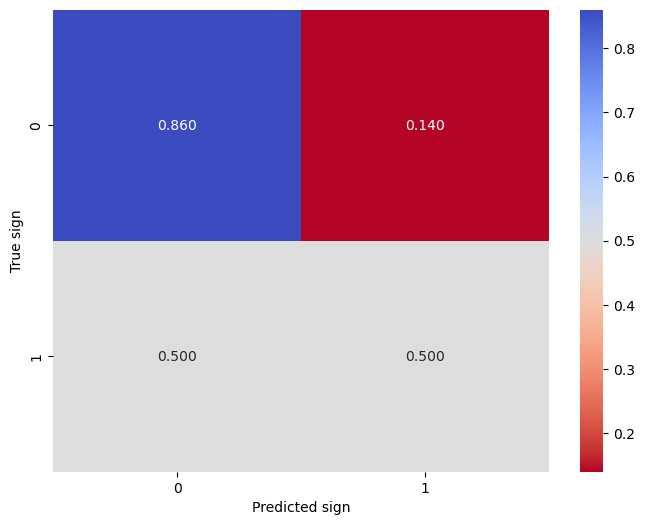

In [180]:
# Create the confusion matrix
matrix(y_test, y_pred)

                    0
std_22      49.475400
^GDAXI      39.351118
GOVT        23.177680
mm_22       11.199087
return       7.920900
range        7.127531
BTC-USD      4.663962
log_ret_1    2.878753
vol_ratio    2.537536
vol_ptc      0.968741
GC=F         0.244478
ETH-USD     -0.791341
mm_50       -4.905374
mm_200      -5.052379
NG=F        -6.436034
ACWI        -7.022264
CL=F        -7.425358
QQQ         -7.576244
^VIX        -8.869333
IWB        -13.227042
SPY        -14.185867
log_ret_2  -14.233909
open_close -14.289138
EURUSD=X   -21.729195
log_ret_3  -22.351507
^HSI       -22.737745
USDJPY=X   -27.191816
^N225      -36.129115


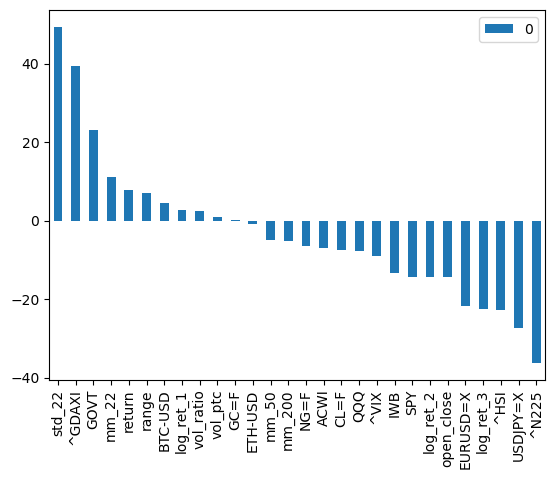

In [181]:
beta_coeff = pd.DataFrame(log_reg.coef_[0], index=X.columns).sort_values(0, ascending=False)
important_features = list(beta_coeff.index)
beta_coeff.plot(kind='bar')
print(beta_coeff)

In [182]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data.sort_values(by='VIF', ascending=False, inplace=True)
print(vif_data.head())

   feature         VIF
7      IWB  269.763031
10     SPY  257.229743
0     ACWI   43.952346
23  mm_200   15.137738
9      QQQ   13.539873


## Backtest

In [183]:
test_df = pd.concat([my_factors, stock_filter], axis=1)[test_start : test_end]

test_df.dropna(inplace=True)
target = test_df[['next_gap']]

test_df.drop('next_gap', axis=1, inplace=True)
predict = log_reg.predict(test_df)
predict_prob = log_reg.predict_proba(test_df)

In [184]:
predict_prob = pd.Series(predict_prob[:,1],  index=test_df.index)
predict_prob.name = 'predict_prob'

predict = pd.Series(predict, index=test_df.index)
predict.name = 'predict'

In [185]:
results = pd.concat([stock, target, predict, predict_prob], axis=1)
results.dropna(inplace=True)

results['discrete_pnl'] = np.log1p(results['Gap'] * results['predict'])
results['discrete_cum_pnl'] = results['discrete_pnl'].cumsum()

results['predict_prob'] = results['predict_prob'].apply(lambda x: 1 if x > signal_threshold else 0)
results['continuos_pnl'] = np.log1p(results['Gap'] * results['predict_prob'])
results['continuos_cum_pnl'] = results['continuos_pnl'].cumsum()
results

,Open,High,Low,Close,Adj Close,Volume,Gap,next_gap,predict,predict_prob,discrete_pnl,discrete_cum_pnl,continuos_pnl,continuos_cum_pnl
Date,,,,,,,,,,,,,,
2022-01-03,335.350006,338.000000,329.779999,334.750000,330.813873,28865100,0.000239,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000
2022-01-04,334.829987,335.200012,326.119995,329.010010,325.141357,32674300,-0.009574,0.0,0.0,0,-0.000000,0.000000,-0.000000,0.000000
2022-01-05,325.859985,326.070007,315.980011,316.380005,312.659851,40054300,-0.010209,0.0,0.0,0,-0.000000,0.000000,-0.000000,0.000000
2022-01-06,313.149994,318.700012,311.489990,313.880005,310.189270,39646100,0.000860,0.0,1.0,0,0.000860,0.000860,0.000000,0.000000
2022-01-07,314.149994,316.500000,310.089996,314.040009,310.347412,32720000,-0.014489,0.0,0.0,0,-0.000000,0.000860,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,279.510010,281.600006,275.369995,275.420013,275.420013,45772200,0.077264,1.0,1.0,1,0.074424,0.131866,0.074424,0.176787
2023-04-26,296.700012,299.570007,292.730011,295.369995,295.369995,64599200,0.002031,0.0,1.0,1,0.002029,0.133895,0.002029,0.178817
2023-04-27,295.970001,305.200012,295.250000,304.829987,304.829987,46462600,-0.002690,0.0,1.0,0,-0.002694,0.131202,-0.000000,0.178817


<Axes: xlabel='Date', ylabel='discrete_cum_pnl'>

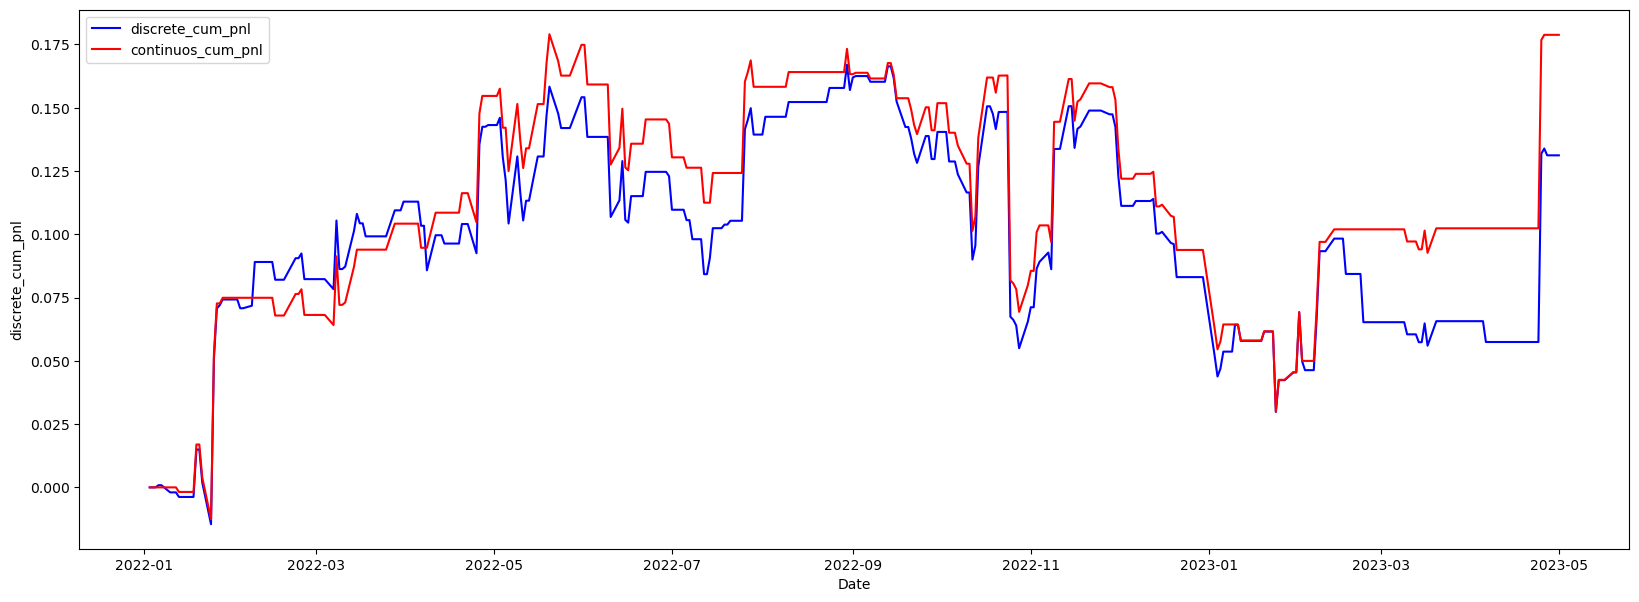

In [186]:
plt.figure(figsize=(20,7))
sns.lineplot(results['discrete_cum_pnl'], label='discrete_cum_pnl', color='blue')
sns.lineplot(results['continuos_cum_pnl'], label='continuos_cum_pnl', color='red')